# Skip-gram Word2Vec

In this notebook, I'll lead you through using PyTorch to implement the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick 
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al.

---
## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of word classes to analyze; one for each word in a vocabulary. Trying to one-hot encode these words is massively inefficient because most values in a one-hot vector will be set to zero. So, the matrix multiplication that happens in between a one-hot input vector and a first, hidden layer will result in mostly zero-valued hidden outputs.

<img src='assets/one_hot_encoding.png' width=50%>

To solve this problem and greatly increase the efficiency of our networks, we use what are called **embeddings**. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

<img src='assets/lookup_matrix.png' width=50%>

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=50%>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

---
## Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

<img src="assets/context_drink.png" width=40%>

Words that show up in similar **contexts**, such as "coffee", "tea", and "water" will have vectors near each other. Different words will be further away from one another, and relationships can be represented by distance in vector space.

<img src="assets/vector_distance.png" width=40%>


There are two architectures for implementing Word2Vec:
>* CBOW (Continuous Bag-Of-Words) and 
* Skip-gram

<img src="assets/word2vec_architectures.png" width=60%>

In this implementation, we'll be using the **skip-gram architecture** because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

---
## Loading Data

Next, we'll ask you to load in data and place it in the `data` directory

1. Load the [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); a file of cleaned up *Wikipedia article text* from Matt Mahoney. 
2. Place that data in the `data` folder in the home directory.
3. Then you can extract it and delete the archive, zip file to save storage space.

After following these steps, you should have one file in your data directory: `data/text8`.

In [1]:
# read in the extracted text file      
with open('data/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Pre-processing

Here I'm fixing up the text to make training easier. This comes from the `utils.py` file. The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. 
* It removes all words that show up five or *fewer* times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.

This may take a few seconds to run, since our text file is quite large. If you want to write your own functions for this stuff, go for it!

In [2]:
import utils

# get list of words
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [3]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


### Dictionaries

Next, I'm creating two dictionaries to convert words to integers and back again (integers to words). This is again done with a function in the `utils.py` file. `create_lookup_tables` takes in a list of words in a text and returns two dictionaries.
>* The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. 

Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [4]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [5]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

def discard_probab(word):
    word_count = word_counts[word]
    num_words = len(int_words)
    frequency = word_count / num_words
    return 1 - np.sqrt(threshold / frequency)

# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = []
for word in int_words:
    p = discard_probab(word)
    if random.random() >= p:
        # Don't discard
        train_words.append(word)

print(train_words[:30])

(5233, 303)
[5233, 194, 45, 476, 10571, 27349, 1, 102, 15067, 58112, 3580, 10712, 2731, 7088, 5233, 10, 44611, 5233, 602, 2621, 8983, 6437, 4186, 5233, 1818, 4860, 6753, 7573, 566, 11064]


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [6]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    # implement this function
    R = random.randint(1, window_size)
    
    first_idx = idx - R if idx - R >= 0 else 0
    last_idx = idx + R if idx + R < len(words) else len(words) - 1
    target = words[first_idx:idx]+ words[idx + 1:last_idx + 1]
    return target

In [7]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [1, 2, 3, 4, 6, 7, 8, 9]


### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [9]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 0, 2, 0, 1, 3, 0, 1, 2]


## Building the graph

Below is an approximate diagram of the general structure of our network.
<img src="assets/skip_gram_net_arch.png" width=60%>

>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

The idea here is to train the embedding layer weight matrix to find efficient representations for our words. We can discard the softmax layer because we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in _other_ networks we build using this dataset.

---
## Validation

Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [10]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

## SkipGram model

Define and train the SkipGram model. 
> You'll need to define an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) and a final, softmax output layer.

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

In [11]:
import torch
from torch import nn
import torch.optim as optim

In [12]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        # complete this SkipGram model
        self.model = nn.Sequential(
            nn.Embedding(n_vocab, n_embed),
            nn.Linear(n_embed, n_vocab),
            nn.Softmax()
        )
    
    def forward(self, x):
        
        # define the forward behavior
        
        return self.model(x)

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

**Note that, because we applied a softmax function to our model output, we are using NLLLoss** as opposed to cross entropy. This is because Softmax  in combination with NLLLoss = CrossEntropy loss.

In [13]:
#!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py

In [19]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=150 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
print(model)

SkipGram(
  (model): Sequential(
    (0): Embedding(63641, 150)
    (1): Linear(in_features=150, out_features=63641, bias=True)
    (2): Softmax(dim=None)
  )
)


In [20]:
#from workspace_utils import active_session

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 2
#with active_session():
# train for some number of epochs
for e in range(epochs):
    print(f"Start {e}")

    # get input and target batches
    for inputs, targets in get_batches(train_words, 32):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)

        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.model[0], device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

Start 0
five | address, redesign, nonaligned, emulates, jre
his | premised, honours, vapor, revolutionary, lieutenants
many | annal, hak, corporal, skydiver, minoan
where | downward, genetics, changes, participatory, princeto
history | blueprint, harrisonburg, hochschild, nanpa, volkssturm
only | giovani, lance, chatting, davidians, shorter
war | exerted, honorifics, honduran, lessens, dinara
this | canopies, cuthbert, diss, icosidodecahedron, bannister
running | mtp, heel, salian, abjads, greenville
account | dhole, recurrence, edm, moldings, thoroughfares
test | heteronormativity, threats, sarajevo, erosion, hexer
egypt | cuzco, venstre, swieten, editor, minimalism
pope | garden, continuously, vicinity, lf, jamaica
existence | rise, blyth, acerbic, insides, gaslight
professional | minicomputer, emaciated, kotoku, businessweek, acquired
square | meades, dipyramid, gly, capablanca, bulk
...
than | copylefted, walpole, abram, romanizations, lackluster
would | shockwaves, modus, lorentz,

b | macedonia, mint, budding, abitur, unwed
six | sidecar, finnegan, neuch, rivest, validity
time | blackadder, burrows, temporarily, harper, inaugural
from | confluence, associates, cadr, shawar, subversion
a | sonorous, conjectured, beard, liminal, iodides
over | hast, sontag, locale, detentions, nanjing
many | hak, annal, corporal, imams, skydiver
seven | kimbundu, spending, occasionally, dirigible, shoku
applications | mim, barney, clathrate, alexanderplatz, tabloids
dr | uniting, cul, paperwork, lexicography, beresford
grand | lemmings, jahan, perceptive, preeminent, fittings
report | grenadian, ostrogothic, trabajo, alm, climate
paris | vitro, overthrowing, borland, vostok, steadily
know | owners, belzec, sooty, freenet, nakata
assembly | affection, resent, doorway, henslow, ms
quite | chastity, hydra, marriage, alston, fornication
...
time | blackadder, burrows, temporarily, harper, inaugural
new | gyroscopic, timeless, estados, pegg, literary
by | backronym, sustainability, cat

into | subsections, dull, matchbox, members, stile
or | meinhof, slicing, capone, passes, tightening
his | premised, vapor, honours, sino, croquet
about | unsatisfied, kasner, lifeboat, blanton, chopper
eight | dynamo, quorum, piccadilly, sneezing, dolphin
been | leftrightarrow, governorates, hypothesize, mysterious, housekeeper
states | navarrese, donkeys, woolsack, attraction, appraisals
known | disneyland, educations, deistic, shrimp, oas
square | dipyramid, gly, meades, diomedes, demonstrator
road | malmesbury, apol, macrae, raps, aron
centre | nye, tile, sibilant, sephiroth, materials
assembly | affection, resent, henslow, ms, doorway
running | salian, abjads, heel, taunting, atrocious
numerous | freemasons, devises, attacks, apocalyptic, tahiti
test | heteronormativity, threats, sarajevo, hexer, ferns
liberal | mecca, alda, curators, severus, separated
...
one | husk, daimler, cryptography, km, corned
after | characterizing, hexokinase, distinctives, laws, reiterates
but | delhi,

will | raster, katharina, nlt, dks, sikhs
such | germ, psychics, geary, viterbo, bertha
states | navarrese, woolsack, donkeys, attraction, appraisals
their | sepiroth, transference, enlightening, brouwer, employment
be | attorneys, gmo, dwt, geary, help
many | annal, hak, imams, corporal, tombs
b | macedonia, mint, unwed, budding, abitur
where | downward, princeto, changes, genetics, snapper
orthodox | extramarital, maasai, lubbock, rethinking, nicene
running | salian, abjads, heel, taunting, atrocious
mainly | addr, prosecutes, numa, wedgwood, mead
except | residing, pads, tony, procedure, novellas
instance | economists, nigra, andr, garnishes, caste
question | armaments, xerox, opteron, parson, wer
recorded | buxtehude, estimation, proclus, edith, stine
placed | embalming, euthanasia, conformed, attersee, warrant
...
from | confluence, associates, cadr, herders, subversion
two | formalist, dal, lyell, pasture, latitudes
one | husk, daimler, cryptography, severe, ajanta
during | tpvga

people | workplace, warrants, homer, chordal, suckling
there | curit, murky, weicker, viacom, judgment
most | kab, the, dorians, temps, yom
their | sepiroth, transference, enlightening, brouwer, employment
not | vicuna, archeology, decides, fanning, najibullah
to | deallocation, cardelli, talked, hesse, rather
it | osceola, optimates, rapper, retro, mingling
called | grime, planck, beac, rovere, cken
animals | hula, labourers, humid, embroidery, pocketful
event | transits, cindy, waldheim, pax, hillsborough
resources | yarborough, mandated, chuck, suleiman, composing
instance | economists, nigra, andr, garnishes, caste
units | philipp, comfort, fingerings, barebones, unsold
operating | noun, abrasax, currently, priory, elegantly
brother | unfretted, usn, apollinaris, garret, correspondent
dr | lexicography, beresford, cul, paperwork, uniting
...
their | sepiroth, transference, enlightening, brouwer, employment
six | sidecar, finnegan, neuch, rivest, jewell
not | vicuna, archeology, dec

also | haggai, marcella, agnosticism, dehydroepiandrosterone, prefered
and | overarching, joukahainen, deflationary, histoire, netanyahu
they | hedgehog, katharine, polygon, extradition, clutching
was | vorder, resolver, spc, sup, obex
about | kasner, lifeboat, unsatisfied, blanton, chopper
american | sht, garson, exchanger, leda, tabor
i | traps, ananias, evened, allocate, suspended
who | wainwright, amy, farad, stettin, aus
mathematics | gatherer, subordinated, revoked, casing, koopman
prince | summon, spooner, institut, kerr, phase
active | asbury, dust, heralds, interception, magen
ice | load, fusion, everly, moller, gautier
professional | minicomputer, emaciated, kotoku, businessweek, magadha
existence | rise, blyth, acerbic, momentum, insides
file | ottokar, polarizing, princeto, hansard, rahula
pressure | veins, eostre, accentuate, pure, kalevala
...
it | osceola, optimates, rapper, retro, mingling
have | staffers, radars, allied, synthesize, arameans
their | sepiroth, transfere

can | scheduler, good, namespace, dirk, ajahn
it | osceola, optimates, rapper, retro, mingling
such | germ, psychics, geary, viterbo, smart
or | meinhof, slicing, capone, revolutionaries, skookum
th | syndicalist, limericks, knack, woodrow, dvg
had | sippar, calvinists, roslin, providing, leche
state | rectum, red, glides, emulates, weaning
be | attorneys, dwt, zanetti, linnaeus, guiana
pre | dre, malicious, contemplate, baptisms, tincture
brother | usn, unfretted, apollinaris, garret, correspondent
behind | dhimma, paganism, chided, ballots, comically
defense | exxon, bougainville, cogito, nicky, whitewater
freedom | reznor, autochthonous, rescheduling, wuthering, casablanca
active | dust, asbury, heralds, magen, framers
existence | rise, blyth, acerbic, momentum, insides
ice | load, fusion, everly, moller, gautier
...
an | musicological, modulated, hollowed, uncountable, ghilzai
with | pixels, pontic, florin, steroid, kimi
between | dilution, hijacked, welsh, farewell, buckminsterful

often | nger, spencer, shuttlecock, perpetrators, parerga
a | sonorous, liminal, jin, sibelius, iodides
have | staffers, radars, arameans, allied, testament
however | security, blasts, troja, nonconfirmative, dagon
most | kab, the, temps, dorians, yom
on | zsa, garofalo, sonorants, misdeeds, booted
use | marry, idiomatic, coots, accountancy, efficiency
other | trunks, allenby, qe, cetacea, field
cost | influential, tinctures, suffice, entablature, aedile
defense | exxon, bougainville, nicky, cogito, combatting
scale | bdp, shamanic, derry, infraction, tosk
rise | existence, hevelius, blacksmith, dwarf, shelley
shows | acosta, hultsfred, repopulated, homeowners, adulthood
award | superhuman, sciences, quarried, head, frailty
existence | rise, blyth, acerbic, momentum, insides
bible | damon, ichkeria, caledonian, complimentary, foes
...
five | address, redesign, nonaligned, leuba, cowl
he | ismaili, cfp, evangelism, spectacular, dao
these | recall, subkey, wild, unbundling, pamplona
more

this | canopies, baud, orissa, owls, convulsive
were | confusion, adventures, dowd, suspense, tunisia
as | reportedly, clo, yggdrasil, minneapolis, ghostbusters
two | formalist, dal, lyell, stimulation, fossilization
had | calvinists, providing, sippar, roslin, leche
most | kab, the, temps, dorians, yom
is | caml, burnley, protagonists, iskcon, cheerful
years | codex, amen, several, newsted, bream
pope | vicinity, lf, khanty, lynching, garden
construction | hydrologic, schaefer, libyan, lawyer, curls
something | bonanza, saadia, sobolev, flo, distortion
channel | aes, shrapnel, sinusoids, warming, artis
versions | roslin, thatcherism, sender, turnips, kabir
mathematics | subordinated, koopman, gatherer, casing, revoked
creation | medi, ry, fils, tiber, aleksei
account | dhole, moldings, recurrence, thoroughfares, edm
...
all | disseminate, ancestries, khyber, het, allegri
time | blackadder, burrows, inaugural, ottawa, ecumenical
no | mouhoun, shriner, faked, alchemists, scientist
four 

as | reportedly, clo, yggdrasil, minneapolis, ghostbusters
states | navarrese, attraction, woolsack, donkeys, appraisals
first | valuable, savate, shrugged, df, deserved
this | canopies, orissa, baud, owls, ko
on | zsa, sonorants, garofalo, misdeeds, booted
two | formalist, dal, lyell, stimulation, fossilization
are | texan, bethlen, gion, greenblatt, ilife
not | vicuna, archeology, marshallese, chartered, najibullah
except | crimes, tony, embodying, carbohydrates, novellas
cost | influential, aedile, tinctures, suffice, entablature
mainly | addr, prosecutes, numa, drug, lcm
older | tefillin, round, opec, isomerism, falsificationism
bbc | lavishly, customize, priorities, rshavn, buell
existence | rise, blyth, acerbic, momentum, insides
articles | incan, inspiring, falco, dunmore, stott
pressure | eostre, veins, accentuate, pure, kalevala
...
these | recall, subkey, wild, unbundling, pamplona
are | texan, bethlen, gion, greenblatt, ilife
time | blackadder, burrows, inaugural, ottawa, ec

after | characterizing, hexokinase, laws, yeager, distinctives
about | kasner, lifeboat, unsatisfied, blanton, chopper
has | ethiopian, uncharacteristically, roundly, favoured, calendrical
nine | factions, odp, clovis, grumman, catherine
a | jin, sonorous, munin, iodides, double
by | backronym, catastrophism, sustainability, captivated, mixtape
people | workplace, warrants, chordal, affliction, suckling
up | coldcut, mycenaean, isopropyl, lumley, bbses
heavy | arbitrariness, satirizes, special, anaphase, annihilation
older | tefillin, opec, round, isomerism, falsificationism
magazine | amos, idiomatically, leopold, solicited, pickford
mean | murphy, productivity, jb, aeons, metabolism
liberal | mecca, alda, bein, severus, curators
taking | specifically, aladi, serbs, marburg, followed
grand | lemmings, jahan, perceptive, preeminent, sudski
proposed | valid, sturgeon, freemen, nmt, matilda
...
not | vicuna, marshallese, archeology, decides, shakers
american | sht, leda, rik, aspires, ex

but | fran, unpredictably, graded, vaporizes, triglyceride
and | overarching, joukahainen, deflationary, histoire, netanyahu
first | valuable, savate, shrugged, df, deserved
who | wainwright, farad, exocet, stettin, icq
th | syndicalist, limericks, knack, opensource, dvg
have | staffers, radars, arameans, allied, profit
system | pia, herz, marketer, prehistoric, cartoonists
were | confusion, adventures, dowd, suspense, tunisia
units | comfort, philipp, fingerings, barebones, unsold
operating | noun, diatessaron, greases, elegantly, wikitravel
instance | andr, economists, nigra, garnishes, grids
bill | sperm, chilled, supercharged, fuselage, currencies
accepted | coq, cartooning, carne, linden, bijective
pope | vicinity, lf, khanty, garden, lynching
question | armaments, xerox, reflecting, parson, pains
event | transits, cindy, waldheim, pax, hillsborough
...
united | hypergiant, curtiss, carvey, appellation, glaxosmithkline
but | fran, unpredictably, graded, vaporizes, triglyceride
s |

were | confusion, adventures, dowd, suspense, tunisia
no | mouhoun, shriner, faked, alchemists, scientist
zero | courageous, vipsanius, massed, p, manatee
is | caml, burnley, protagonists, iskcon, cheerful
the | most, kruger, founding, schists, succinite
some | acidosis, wives, ibos, jacques, ben
if | carbine, jansenism, stripes, gobi, garnishes
so | invictus, welding, essendon, airships, captures
creation | medi, ry, ils, sportsmen, sansom
taking | specifically, aladi, followed, serbs, paullus
woman | baylor, komodoensis, merle, hearing, unquestionable
alternative | mahabad, belly, commonwealth, faintly, bling
universe | intimidation, otherness, injection, mitnagdim, approximately
instance | andr, economists, nigra, garnishes, bahraini
writers | pentium, occlude, maariv, psara, labrador
operating | noun, diatessaron, conical, wikitravel, elegantly
...
and | overarching, joukahainen, deflationary, histoire, netanyahu
such | germ, geary, psychics, smart, macht
to | deallocation, cardell

history | blueprint, hochschild, harrisonburg, volkssturm, described
had | calvinists, providing, sippar, roslin, enemies
however | security, troja, blasts, nonconfirmative, dagon
this | canopies, baud, owls, krugman, pfalz
nine | factions, odp, clovis, grumman, catherine
called | grime, beac, planck, spacetimes, rovere
seven | occasionally, kimbundu, dirigible, shoku, spending
its | farmed, complementary, persists, iala, cga
file | ottokar, polarizing, princeto, hansard, rahula
placed | embalming, warrant, callixtus, attersee, euthanasia
existence | rise, acerbic, blyth, momentum, chiastic
question | armaments, xerox, reflecting, parson, pains
powers | bite, efik, wrong, benedictine, constantinople
scale | bdp, derry, shamanic, infraction, tosk
something | bonanza, sobolev, flo, saadia, lounge
lived | cis, tley, omne, dirks, ackerman
...
or | meinhof, slicing, capone, skookum, revolutionaries
not | vicuna, marshallese, archeology, documentaries, decides
their | sepiroth, transference,

be | attorneys, zanetti, blended, linnaeus, dwt
i | traps, ananias, evened, allocate, suspended
a | jin, munin, sonorous, iodides, double
states | navarrese, donkeys, attraction, woolsack, appraisals
all | disseminate, ancestries, chaparral, khyber, haute
after | characterizing, hexokinase, laws, yeager, distinctives
such | germ, geary, psychics, smart, macht
six | finnegan, neuch, validity, sidecar, daron
know | owners, rebuttal, freenet, belzec, asphalt
brother | usn, garret, unfretted, apollinaris, harmonize
joseph | restricted, churchmen, maier, dsm, pcs
stage | francoist, schelling, bagley, vlaams, schulz
woman | baylor, merle, komodoensis, obscures, hearing
accepted | coq, cartooning, carne, linden, bijective
scale | bdp, derry, shamanic, infraction, tosk
san | sainte, limehouse, grue, vuk, lytton
...
such | germ, geary, psychics, smart, macht
i | traps, ananias, evened, allocate, suspended
five | redesign, reprint, cowl, cleartype, address
had | calvinists, providing, sippar, ro

time | blackadder, burrows, inaugural, ottawa, ecumenical
however | security, troja, blasts, nonconfirmative, dagon
three | gerson, bc, swath, toile, devin
state | rectum, red, glides, emulates, weaning
into | subsections, dull, apparitions, matchbox, stile
but | fran, unpredictably, graded, vaporizes, triglyceride
s | admiral, phineus, garages, clarinetists, karakoram
an | musicological, modulated, hollowed, uncountable, ghilzai
operating | noun, diatessaron, conical, elegantly, wikitravel
gold | falciparum, desi, techno, centimetres, biomes
road | apol, malmesbury, aron, raps, khanna
scale | bdp, derry, shamanic, infraction, tosk
pope | vicinity, garden, lf, khanty, lynching
joseph | restricted, churchmen, maier, dsm, exert
powers | bite, efik, wrong, benedictine, constantinople
mean | murphy, productivity, jb, metabolism, aeons
...
be | attorneys, zanetti, guiana, blended, linnaeus
were | confusion, adventures, dowd, bridgewater, suspense
also | haggai, agnosticism, dehydroepiandros

new | zener, estados, mayakovsky, hyperthermia, gyroscopic
only | giovani, shorter, lance, chatting, davidians
often | nger, spencer, shuttlecock, epicenter, parerga
seven | occasionally, kimbundu, dirigible, shoku, spending
an | musicological, modulated, hollowed, uncountable, ghilzai
many | annal, hak, imams, tombs, corporal
time | blackadder, burrows, inaugural, ottawa, ecumenical
or | meinhof, slicing, capone, tightening, skookum
joseph | restricted, churchmen, maier, dsm, exert
consists | maw, precisely, timekeeping, bolus, mandelbrot
bbc | lavishly, customize, priorities, rshavn, buell
issue | sintered, cheesy, rodriguez, ale, retrace
pope | vicinity, garden, lf, khanty, lynching
older | tefillin, opec, isomerism, kilts, purport
hold | fulfilling, iii, apoplexy, leeway, shammai
test | heteronormativity, ferns, threats, webpages, sarajevo
...
and | overarching, joukahainen, deflationary, histoire, netanyahu
has | ethiopian, uncharacteristically, roundly, calendrical, falsely
of | 

state | rectum, red, glides, emulates, weaning
they | interfaces, nit, katharine, polygon, hoyle
would | lorentz, shockwaves, delphic, usn, epiphany
however | security, troja, blasts, nonconfirmative, dagon
may | espanol, interfacing, rackets, relevant, fpgas
s | phineus, admiral, garages, clarinetists, karakoram
during | puritanical, tpvgames, rodeo, topkapi, elliptical
these | recall, subkey, wild, unbundling, pamplona
instance | andr, economists, nigra, garnishes, morgue
liberal | mecca, alda, bein, curators, severus
applied | verified, saxons, muriel, hiroshi, terrorists
construction | hydrologic, libyan, schaefer, bacterial, sim
behind | speech, dhimma, chided, paganism, chivalric
road | apol, aron, malmesbury, khanna, raps
nobel | seers, cofinal, perelman, refuel, colampadius
primarily | recreations, quux, defined, phan, decidable
...
also | haggai, agnosticism, dehydroepiandrosterone, marcella, libation
after | characterizing, laws, yeager, hexokinase, distinctives
about | kasne

most | kab, the, temps, fears, dorians
people | workplace, warrants, percussion, chordal, affliction
had | providing, sippar, calvinists, roslin, enemies
at | juggernaut, astrid, etruria, disdainful, nietzsche
with | pixels, florin, pontic, steroid, kimi
time | blackadder, burrows, inaugural, ottawa, ecumenical
of | caress, liliaceae, british, flick, sludge
after | characterizing, laws, yeager, hexokinase, distinctives
mean | murphy, productivity, jb, metabolism, aeons
creation | vetoing, ils, medi, sansom, ry
brother | apollinaris, unfretted, usn, caused, garret
channel | aes, shrapnel, sinusoids, artis, warming
versions | roslin, thatcherism, sender, bussard, turnips
experience | reappointed, longwave, tuan, altimeter, husbandry
police | cerrado, publications, coventry, meddle, vessels
marriage | detriment, licensees, quite, komatsu, extending
...
three | gerson, bc, annually, swath, toile
over | nanjing, hast, sontag, noc, detentions
were | adventures, confusion, soldiers, dowd, bri

one | km, severe, daimler, cryptography, revised
would | lorentz, shockwaves, delphic, usn, epiphany
its | farmed, persists, cga, reymond, iala
and | overarching, joukahainen, deflationary, histoire, netanyahu
nine | factions, odp, clovis, grumman, catherine
d | gomoku, jigger, thicker, molestation, commemorate
years | codex, amen, newsted, bream, renewal
use | marry, capensis, coots, ranjit, delhomme
brother | apollinaris, unfretted, usn, caused, garret
lived | cis, tley, omne, marlins, dirks
recorded | buxtehude, proclus, estimation, edith, stine
question | armaments, xerox, reflecting, parson, pains
something | bonanza, distortion, flo, saadia, sobolev
engine | vp, compact, zed, musket, ananke
operating | noun, diatessaron, conical, heeled, priory
applications | mim, clathrate, rickenbacker, tabloids, barney
...
his | vapor, sino, premised, croquet, enjoyable
often | nger, spencer, shuttlecock, epicenter, virulent
was | vorder, sup, resolver, spc, doubled
an | musicological, modulat

world | germany, earn, blackbeard, emailed, mazurek
also | haggai, agnosticism, dehydroepiandrosterone, marcella, libation
which | dogmatism, lar, jebel, offense, habitus
see | esk, hopf, although, thoroughfares, portraying
six | finnegan, neuch, validity, sidecar, daron
have | staffers, radars, barrier, arameans, vasa
th | syndicalist, limericks, knack, woodrow, opensource
were | adventures, confusion, dowd, soldiers, bridgewater
gold | falciparum, desi, centimetres, biomes, lecithin
stage | francoist, schelling, bagley, vlaams, schulz
consists | maw, timekeeping, precisely, bolus, familiarity
versions | roslin, thatcherism, sender, bussard, turnips
engineering | mcgovern, rookies, roll, ambrosian, glamorous
creation | vetoing, ils, medi, sansom, ry
experience | reappointed, altimeter, longwave, tuan, fabien
mean | murphy, productivity, jb, metabolism, aeons
...
known | disneyland, deistic, oas, dactyl, shrimp
while | functionalists, kickers, clintons, koninklijke, conformist
three | 

b | mint, space, abomination, summa, macedonia
after | characterizing, laws, yeager, hexokinase, distinctives
six | finnegan, neuch, validity, sidecar, pikes
of | caress, liliaceae, british, flick, sludge
i | traps, ananias, evened, allocate, suspended
will | raster, sikhs, katharina, nlt, dks
seven | occasionally, kimbundu, dirigible, shoku, spending
while | functionalists, kickers, clintons, koninklijke, conformist
ice | load, fusion, everly, moller, bathsheba
operations | appearing, lifespan, superlatives, nonnus, necronomicon
additional | mushroom, secam, lacquer, ethnology, walt
something | bonanza, distortion, flo, saadia, sobolev
writers | pentium, occlude, labrador, rds, maariv
proposed | valid, sturgeon, freemen, nmt, inclusion
woman | baylor, merle, komodoensis, obscures, hearing
resources | yarborough, mandated, mistaking, ovale, worcestershire
...
new | zener, estados, gyroscopic, mayakovsky, lutheran
about | kasner, lifeboat, damaged, unsatisfied, blanton
s | phineus, admi

a | jin, munin, double, iodides, sonorous
d | gomoku, thicker, jigger, molestation, commemorate
see | esk, hopf, although, thoroughfares, portraying
history | blueprint, hochschild, harrisonburg, volkssturm, described
such | germ, geary, psychics, smart, macht
than | romanizations, copylefted, lackluster, walpole, langevin
used | gael, eileen, fugitive, enamoured, poto
there | curit, handheld, rafael, murky, hc
creation | vetoing, ils, medi, sansom, ry
instance | andr, economists, nigra, garnishes, piccadilly
file | ottokar, polarizing, hansard, unachievable, topographical
question | armaments, xerox, reflecting, parson, pains
running | taunting, salian, bmi, abjads, heel
bbc | lavishly, customize, priorities, rshavn, buell
animals | labourers, embroidery, hula, humid, ldap
mainly | addr, prosecutes, numa, lcm, wedgwood
...
is | caml, burnley, jenny, iskcon, protagonists
these | recall, subkey, wild, unbundling, pamplona
for | nuclear, doubted, matin, anticonvulsants, wannsee
a | jin, 

united | hypergiant, curtiss, appellation, carvey, glaxosmithkline
be | attorneys, zanetti, guiana, blended, linnaeus
zero | courageous, vipsanius, massed, manatee, quinlan
of | caress, liliaceae, british, flick, sludge
their | sepiroth, transference, brouwer, enlightening, employment
which | dogmatism, lar, offense, jebel, habitus
about | kasner, lifeboat, damaged, unsatisfied, blanton
there | curit, handheld, rafael, murky, hc
proposed | valid, sturgeon, freemen, nmt, matilda
troops | unless, tavern, spine, hypro, budgets
primarily | recreations, quux, decidable, defined, phan
arts | nonliving, hawthorne, sprouse, distinctively, sexton
ocean | cocoanuts, abyss, pyrotechnic, sethi, silkworth
award | superhuman, sciences, head, frailty, quarried
creation | vetoing, ils, ry, medi, sansom
egypt | cuzco, seoul, swieten, prophetic, replicators
...
five | redesign, cowl, cleartype, three, leuba
however | security, nonconfirmative, troja, dagon, seaworld
only | giovani, lance, chatting, shor

b | mint, abomination, space, summa, macedonia
their | sepiroth, transference, brouwer, enlightening, employment
see | esk, hopf, although, thoroughfares, portraying
by | backronym, catastrophism, mucosa, captivated, urdu
use | marry, capensis, coots, ranjit, delhomme
between | dilution, hijacked, sonorous, without, auckland
his | vapor, sino, premised, croquet, enjoyable
but | unpredictably, graded, vaporizes, triglyceride, skins
orthodox | maasai, extramarital, mused, lubbock, rethinking
question | armaments, xerox, reflecting, parson, pains
ocean | cocoanuts, abyss, pyrotechnic, sethi, silkworth
file | ottokar, polarizing, hansard, unachievable, princeto
operations | appearing, superlatives, lifespan, nonnus, necronomicon
experience | reappointed, altimeter, longwave, tuan, fabien
engine | compact, vp, zed, musket, ananke
bbc | lavishly, customize, priorities, rshavn, buell
...
used | gael, fugitive, eileen, snowboarding, enamoured
its | farmed, corky, iala, persists, cga
only | gio

seven | occasionally, kimbundu, dirigible, shoku, spending
not | vicuna, marshallese, archeology, documentaries, decides
are | texan, bethlen, greenblatt, ilife, bacterium
his | vapor, sino, premised, croquet, enjoyable
zero | courageous, vipsanius, massed, manatee, quinlan
who | wainwright, farad, any, fish, exocet
it | osceola, optimates, rapper, retro, outings
states | navarrese, donkeys, woolsack, attraction, appraisals
engineering | mcgovern, rookies, roll, ambrosian, suva
animals | labourers, embroidery, hula, humid, ldap
resources | yarborough, mandated, mistaking, ovale, worcestershire
centre | nye, arose, capoeira, tile, sephiroth
defense | exxon, bougainville, nicky, combatting, cogito
quite | chastity, akm, marriage, fornication, botham
hold | fulfilling, iii, apoplexy, muddled, leeway
nobel | seers, cofinal, perelman, theologian, colampadius
...
such | germ, geary, psychics, smart, macht
world | germany, earn, blackbeard, emailed, mazurek
an | musicological, modulated, holl

than | romanizations, copylefted, lackluster, walpole, langevin
only | shorter, giovani, lance, chatting, davidians
was | vorder, sup, resolver, spc, doubled
when | hdi, woodlawn, arborway, synaptic, merthyr
called | grime, planck, beac, spacetimes, conversant
his | vapor, sino, premised, croquet, enjoyable
two | formalist, fossilization, lyell, dal, gigs
such | germ, geary, psychics, smart, macht
road | apol, malmesbury, aron, khanna, raps
operations | appearing, superlatives, lifespan, nonnus, necronomicon
universe | intimidation, mitnagdim, otherness, approximately, injection
pope | vicinity, khanty, garden, lf, lynching
experience | reappointed, altimeter, longwave, tuan, fabien
test | heteronormativity, ferns, threats, webpages, sarajevo
consists | maw, timekeeping, bolus, familiarity, mandelbrot
institute | aamir, exponentials, seigenthaler, avenue, proportionate
...
they | interfaces, nit, locarno, hedgehog, katharine
and | overarching, joukahainen, deflationary, histoire, photo

a | jin, munin, double, iodides, sonorous
and | overarching, joukahainen, deflationary, histoire, photocopying
states | navarrese, donkeys, woolsack, attraction, appraisals
many | imams, annal, hak, tombs, corporal
up | coldcut, mycenaean, isopropyl, lumley, bbses
also | haggai, agnosticism, dehydroepiandrosterone, marcella, libation
which | dogmatism, lar, offense, jebel, habitus
its | farmed, corky, iala, reymond, cabbages
engine | compact, vp, zed, musket, ananke
troops | unless, tavern, spine, hypro, budgets
pressure | eostre, maritsa, spirituality, extends, ejecting
nobel | seers, cofinal, perelman, theologian, introductory
discovered | infibulation, marbury, acoustic, reconfiguration, lehrbuch
governor | hard, vil, custodians, towers, abrogation
bill | chilled, supercharged, sperm, fuselage, selfish
universe | intimidation, mitnagdim, otherness, approximately, injection
...
time | blackadder, burrows, inaugural, ottawa, ecumenical
american | sht, leda, rik, aspires, prevention
kn

five | cowl, redesign, three, leuba, twins
these | recall, subkey, wild, unbundling, pamplona
as | reportedly, clo, yggdrasil, minneapolis, ghostbusters
th | syndicalist, limericks, knack, woodrow, opensource
four | pristine, torah, fluoride, vaginal, ly
between | dilution, hijacked, sonorous, without, auckland
used | gael, fugitive, eileen, snowboarding, loyalty
zero | courageous, vipsanius, massed, manatee, quinlan
placed | embalming, warrant, callixtus, attersee, euthanasia
orthodox | maasai, extramarital, mused, lubbock, rethinking
event | transits, waldheim, cindy, pax, hillsborough
shows | hultsfred, acosta, homeowners, repopulated, burghs
proposed | valid, sturgeon, freemen, nmt, matilda
recorded | buxtehude, proclus, estimation, edith, stine
nobel | seers, cofinal, perelman, theologian, introductory
bill | chilled, supercharged, sperm, fuselage, selfish
...
when | hdi, adb, woodlawn, arborway, synaptic
s | phineus, admiral, garages, clarinetists, karakoram
it | osceola, optimat

for | nuclear, anticonvulsants, matin, doubted, ldc
however | security, nonconfirmative, troja, dagon, seaworld
only | shorter, giovani, lance, chatting, davidians
an | musicological, modulated, hollowed, uncountable, ghilzai
where | downward, genetics, princeto, changes, snapper
and | overarching, joukahainen, deflationary, histoire, photocopying
one | km, severe, daimler, revised, cryptography
often | nger, spencer, shuttlecock, virulent, epicenter
lived | cis, tley, omne, geologist, marlins
additional | mushroom, secam, lacquer, ethnology, walt
construction | hydrologic, libyan, schaefer, bacterial, sim
centre | nye, arose, capoeira, sephiroth, scoped
governor | hard, vil, custodians, towers, abrogation
test | heteronormativity, ferns, threats, webpages, sarajevo
bible | ichkeria, foes, damon, roos, caledonian
shows | hultsfred, acosta, homeowners, repopulated, burghs
...
been | leftrightarrow, governorates, mysterious, hypothesize, drinkers
from | confluence, cadr, associates, herd

known | disneyland, deistic, oas, dactyl, urinary
between | dilution, hijacked, sonorous, without, auckland
after | characterizing, laws, yeager, hexokinase, distinctives
these | recall, subkey, wild, unbundling, pamplona
during | puritanical, tpvgames, rodeo, topkapi, elliptical
this | canopies, baud, owls, krugman, pfalz
are | texan, bethlen, greenblatt, ilife, bacterium
nine | factions, odp, catherine, grumman, athlete
know | owners, rebuttal, belzec, asphalt, benefits
proposed | valid, freemen, nmt, sturgeon, inclusion
instance | andr, nigra, triumphant, economists, kings
mean | productivity, murphy, jb, metabolism, aeons
channel | shrapnel, aes, sinusoids, artis, warming
construction | hydrologic, libyan, schaefer, bacterial, sim
heavy | arbitrariness, grammatical, satirizes, special, whitlam
consists | maw, timekeeping, bolus, familiarity, mandelbrot
...
would | lorentz, shockwaves, delphic, usn, epiphany
that | presque, chromaticity, cnc, bachelor, anglia
over | sontag, hast, de

as | reportedly, clo, yggdrasil, minneapolis, ghostbusters
been | leftrightarrow, governorates, mysterious, hypothesize, drinkers
no | shriner, mouhoun, alchemists, scientist, faked
by | backronym, catastrophism, mucosa, captivated, urdu
would | lorentz, shockwaves, delphic, usn, epiphany
to | talked, cardelli, hesse, deallocation, animists
will | raster, sikhs, katharina, nlt, dks
history | blueprint, hochschild, harrisonburg, volkssturm, described
lived | cis, tley, omne, geologist, marlins
experience | reappointed, altimeter, longwave, tuan, fabien
applications | mim, clathrate, rickenbacker, barney, rumour
know | owners, rebuttal, belzec, asphalt, benefits
dr | cul, lexicography, paperwork, middlesbrough, mindy
troops | unless, tavern, spine, hypro, budgets
paris | overthrowing, borland, vitro, steadily, gaff
operations | appearing, superlatives, lifespan, nonnus, necronomicon
...
if | stripes, jansenism, carbine, javelin, intimate
from | confluence, cadr, associates, herders, subv

this | canopies, baud, owls, krugman, practicing
th | syndicalist, limericks, knack, woodrow, opensource
been | leftrightarrow, governorates, mysterious, hypothesize, examination
are | texan, bethlen, greenblatt, ilife, bacterium
was | vorder, sup, resolver, spc, doubled
would | lorentz, shockwaves, delphic, usn, epiphany
who | wainwright, farad, any, fish, exocet
an | musicological, modulated, hollowed, uncountable, ghilzai
recorded | buxtehude, proclus, estimation, edith, stine
resources | yarborough, mandated, mistaking, ovale, worcestershire
arts | nonliving, hawthorne, sprouse, constitutional, distinctively
egypt | cuzco, seoul, swieten, prophetic, replicators
powers | wrong, bite, efik, benedictine, lessened
running | taunting, salian, bmi, abjads, heel
additional | mushroom, secam, lacquer, ethnology, walt
accepted | coq, cartooning, carne, linden, contendere
...
used | gael, fugitive, eileen, snowboarding, loyalty
may | espanol, interfacing, rackets, fpgas, masculism
they | int

s | phineus, garages, clashes, admiral, clarinetists
used | gael, fugitive, eileen, snowboarding, loyalty
three | bc, gerson, five, annually, motoring
to | talked, cardelli, hesse, deallocation, animists
not | vicuna, decides, marshallese, archeology, documentaries
people | workplace, warrants, percussion, chordal, homer
are | texan, bethlen, greenblatt, ilife, bacterium
five | cowl, three, redesign, twins, leuba
know | owners, rebuttal, belzec, asphalt, benefits
additional | mushroom, secam, lacquer, ethnology, walt
applications | mim, rickenbacker, rumour, barney, clathrate
question | armaments, xerox, reflecting, pains, opteron
accepted | coq, cartooning, carne, linden, contendere
channel | shrapnel, aes, sinusoids, artis, warming
liberal | mecca, alda, curators, severus, fantasy
http | htm, centrifugal, because, coler, monoculture
...
with | pixels, steroid, florin, kimi, pontic
when | hdi, woodlawn, arborway, merthyr, abolish
has | ethiopian, uncharacteristically, roundly, hideaki

if | stripes, jansenism, carbine, javelin, intimate
states | navarrese, donkeys, woolsack, attraction, appraisals
and | overarching, joukahainen, deflationary, histoire, photocopying
while | functionalists, clintons, kickers, koninklijke, conformist
it | osceola, optimates, rapper, retro, outings
his | vapor, sino, premised, croquet, enjoyable
five | cowl, three, redesign, twins, leuba
however | security, nonconfirmative, troja, dagon, seaworld
test | heteronormativity, ferns, threats, webpages, sarajevo
derived | chemists, mayoral, malfeasance, health, dwelling
joseph | restricted, churchmen, maier, decreased, dsm
engine | vp, compact, zed, musket, ananke
file | ottokar, polarizing, hansard, princeto, rahula
pre | dre, malicious, richard, baptisms, contemplate
primarily | recreations, quux, defined, decidable, phan
existence | rise, blyth, acerbic, momentum, chiastic
...
united | hypergiant, appellation, curtiss, wav, carvey
by | backronym, catastrophism, mucosa, captivated, urdu
than

new | zener, estados, gyroscopic, hyperthermia, censuses
one | km, severe, revised, daimler, cryptography
seven | kimbundu, occasionally, spending, cochrane, dirigible
may | espanol, interfacing, rackets, fpgas, masculism
the | most, kruger, schists, tryin, succinite
he | ismaili, spectacular, cfp, twas, windings
been | leftrightarrow, governorates, mysterious, hypothesize, examination
about | kasner, damaged, lifeboat, unsatisfied, blanton
test | heteronormativity, ferns, threats, webpages, sarajevo
alternative | commonwealth, mahabad, faintly, bling, belly
applied | verified, muriel, saxons, hiroshi, feldspars
channel | aes, shrapnel, sinusoids, artis, warming
cost | influential, aedile, reductions, entablature, nineteenth
gold | falciparum, desi, centimetres, biomes, lecithin
heavy | arbitrariness, grammatical, satirizes, special, whitlam
nobel | seers, cofinal, perelman, theologian, introductory
...
seven | kimbundu, occasionally, spending, cochrane, dirigible
called | grime, beac,

which | dogmatism, lar, offense, jebel, habitus
zero | p, courageous, mug, quinlan, vipsanius
no | shriner, mouhoun, alchemists, scientist, brl
world | germany, earn, blackbeard, famers, copy
five | cowl, three, redesign, twins, leuba
s | phineus, garages, clashes, admiral, clarinetists
or | meinhof, slicing, capone, skookum, tightening
was | vorder, sup, resolver, spc, doubled
mainly | addr, prosecutes, numa, panarion, wedgwood
something | bonanza, distortion, flo, sobolev, lounge
applications | mim, rickenbacker, rumour, barney, clathrate
writers | occlude, pentium, labrador, revel, rds
stage | francoist, bagley, schelling, vlaams, en
event | transits, waldheim, cindy, pax, hillsborough
marriage | detriment, licensees, original, offutt, komatsu
scale | bdp, derry, shamanic, infraction, tosk
...
most | kab, the, temps, fears, dorians
with | pixels, steroid, florin, kimi, pontic
not | vicuna, decides, marshallese, archeology, documentaries
so | invictus, welding, airships, essendon, ca

while | functionalists, clintons, kickers, koninklijke, conformist
years | codex, amen, renewal, prosper, bream
may | espanol, interfacing, rackets, fpgas, masculism
many | imams, annal, hak, tombs, minoan
had | providing, sippar, calvinists, enemies, roslin
it | osceola, optimates, rapper, retro, outings
into | subsections, dull, apparitions, matchbox, stile
six | finnegan, neuch, sidecar, grands, teflon
stage | francoist, bagley, schelling, vlaams, en
behind | speech, paganism, ballots, dhimma, chided
active | catering, asbury, heralds, magazines, dust
pressure | eostre, maritsa, spirituality, conquer, ejecting
engine | vp, compact, zed, musket, ananke
brother | apollinaris, caused, harmonize, usn, unfretted
derived | chemists, mayoral, malfeasance, health, dwelling
discovered | infibulation, acoustic, marbury, reconfiguration, lehrbuch
...
eight | quorum, qb, dynamo, anova, recaptured
also | prefered, haggai, centripetal, ranges, libation
not | vicuna, decides, marshallese, archeolo

years | codex, amen, renewal, prosper, bream
by | backronym, catastrophism, mucosa, captivated, urdu
been | leftrightarrow, governorates, mysterious, hypothesize, drinkers
was | vorder, sup, resolver, spc, doubled
will | raster, sikhs, katharina, nlt, dks
to | talked, cardelli, hesse, deallocation, animists
on | zsa, sonorants, garofalo, misdeeds, booted
five | cowl, redesign, three, twins, leuba
question | armaments, xerox, reflecting, pains, opteron
additional | mushroom, secam, lacquer, ethnology, walt
notes | painters, nipples, meitnerium, alien, shapes
operations | appearing, lifespan, superlatives, nonnus, necronomicon
placed | embalming, warrant, callixtus, attersee, serie
proposed | valid, freemen, nmt, inclusion, sturgeon
rise | existence, hevelius, blacksmith, dwarf, shelley
square | dipyramid, meades, gly, diomedes, demonstrator
...
however | security, nonconfirmative, troja, dagon, seaworld
seven | kimbundu, occasionally, spending, cochrane, dirigible
zero | courageous, vip

zero | courageous, vipsanius, ebert, p, massed
many | imams, annal, hak, tombs, minoan
such | germ, geary, psychics, macht, hinge
has | ethiopian, roundly, uncharacteristically, calendrical, eteocretan
new | zener, estados, gyroscopic, hyperthermia, censuses
about | kasner, lifeboat, damaged, unsatisfied, blanton
one | km, severe, revised, daimler, cryptography
however | security, nonconfirmative, troja, dagon, seaworld
mean | productivity, murphy, jb, aeons, metabolism
taking | specifically, aladi, followed, serbs, paullus
test | heteronormativity, ferns, threats, webpages, sarajevo
placed | embalming, warrant, callixtus, attersee, serie
event | transits, waldheim, cindy, pax, hillsborough
road | apol, malmesbury, aron, khanna, raps
egypt | cuzco, seoul, swieten, prophetic, replicators
operating | noun, diatessaron, elegantly, theologico, priory
...
its | farmed, corky, iala, cga, reymond
three | bc, gerson, five, motoring, annually
about | kasner, lifeboat, damaged, unsatisfied, blan

an | musicological, modulated, hollowed, uncountable, ghilzai
and | overarching, joukahainen, deflationary, histoire, photocopying
state | rectum, red, glides, emulates, casteljau
while | functionalists, clintons, kickers, koninklijke, conformist
by | backronym, catastrophism, mucosa, captivated, urdu
in | practiced, butterfly, violoncello, connery, glazer
used | gael, eileen, snowboarding, loyalty, poto
american | sht, leda, rik, aspires, exchanger
discovered | infibulation, acoustic, marbury, reconfiguration, ofcom
hit | inversional, syndicated, endless, arteriovenous, maccoll
versions | roslin, thatcherism, sender, bussard, turnips
pressure | eostre, maritsa, spirituality, ejecting, accentuate
something | bonanza, distortion, flo, sobolev, lounge
recorded | buxtehude, proclus, estimation, edith, stine
ocean | cocoanuts, abyss, pyrotechnic, sethi, silkworth
active | catering, asbury, heralds, dust, magazines
...
it | osceola, optimates, rapper, retro, outings
united | hypergiant, app

a | jin, munin, double, iodides, sonorous
for | nuclear, anticonvulsants, matin, doubted, favourite
over | sontag, detentions, locale, nanjing, noc
are | texan, bethlen, greenblatt, ilife, bacterium
other | trunks, allenby, manar, qe, elsinore
was | vorder, sup, resolver, spc, doubled
the | most, kruger, schists, tryin, succinite
his | vapor, sino, premised, croquet, enjoyable
existence | rise, blyth, acerbic, momentum, chiastic
alternative | commonwealth, mahabad, faintly, bling, belly
joseph | restricted, churchmen, maier, decreased, dsm
award | superhuman, sciences, head, frailty, quarried
active | catering, asbury, heralds, dust, magazines
gold | falciparum, desi, centimetres, biomes, lecithin
woman | baylor, merle, komodoensis, obscures, unquestionable
magazine | amos, idiomatically, solicited, ibid, pickford
...
people | workplace, warrants, percussion, chordal, homer
is | caml, burnley, jenny, streets, iskcon
of | caress, liliaceae, british, flick, sludge
years | codex, amen, re

been | leftrightarrow, governorates, mysterious, hypothesize, examination
over | sontag, detentions, locale, nanjing, noc
from | confluence, cadr, associates, herders, subversion
as | reportedly, clo, yggdrasil, minneapolis, ghostbusters
it | osceola, optimates, rapper, retro, outings
this | canopies, baud, owls, krugman, practicing
a | jin, munin, double, iodides, sonorous
seven | kimbundu, occasionally, spending, cochrane, dirigible
channel | aes, shrapnel, artis, sinusoids, warming
alternative | commonwealth, mahabad, faintly, bling, belly
heavy | arbitrariness, grammatical, satirizes, special, whitlam
nobel | seers, cofinal, perelman, theologian, refuel
grand | lemmings, jahan, perceptive, fittings, sudski
question | armaments, xerox, reflecting, pains, opteron
joseph | restricted, churchmen, maier, decreased, dsm
liberal | mecca, alda, curators, severus, fantasy
...
nine | factions, odp, catherine, grumman, athlete
had | providing, sippar, calvinists, enemies, roslin
use | marry, 

states | donkeys, woolsack, navarrese, attraction, appraisals
s | phineus, garages, clashes, admiral, clarinetists
state | rectum, red, glides, emulates, casteljau
after | characterizing, laws, yeager, nicholson, distinctives
six | finnegan, neuch, sidecar, grands, teflon
known | disneyland, deistic, oas, dactyl, urinary
when | hdi, woodlawn, arborway, rosser, merthyr
american | sht, leda, rik, aspires, exchanger
issue | sintered, rodriguez, turntable, ale, retrace
scale | bdp, derry, shamanic, prostitutes, infraction
event | transits, waldheim, cindy, pax, hillsborough
http | htm, centrifugal, because, coler, monoculture
numerous | freemasons, attacks, tahiti, devises, burman
shown | vytautas, collective, kristofferson, situational, coulsdon
universe | intimidation, mitnagdim, otherness, approximately, injection
police | cerrado, publications, coventry, meddle, wf
...
or | meinhof, slicing, capone, tightening, skookum
but | unpredictably, graded, vaporizes, triglyceride, skins
th | sy

with | pixels, steroid, kimi, pontic, atheism
first | valuable, savate, df, shrugged, deserved
world | germany, earn, blackbeard, famers, copy
while | functionalists, clintons, kickers, koninklijke, conformist
up | coldcut, mycenaean, isopropyl, lumley, bbses
people | workplace, warrants, percussion, chordal, homer
zero | courageous, vipsanius, ebert, massed, p
is | caml, burnley, jenny, streets, iskcon
existence | rise, blyth, acerbic, momentum, chiastic
know | owners, rebuttal, belzec, benefits, asphalt
mainly | addr, numa, prosecutes, panarion, mead
additional | mushroom, secam, lacquer, ethnology, walt
test | heteronormativity, ferns, threats, webpages, sarajevo
universe | intimidation, mitnagdim, otherness, approximately, injection
shown | vytautas, collective, kristofferson, situational, coulsdon
question | armaments, xerox, reflecting, pains, opteron
...
one | km, severe, revised, daimler, cryptography
however | security, nonconfirmative, troja, dagon, seaworld
was | vorder, sup

would | lorentz, shockwaves, delphic, areas, epiphany
had | providing, sippar, calvinists, enemies, roslin
known | disneyland, deistic, oas, dactyl, urinary
two | dal, formalist, lyell, socio, gigs
use | marry, capensis, coots, ranjit, delhomme
but | unpredictably, graded, vaporizes, triglyceride, skins
be | attorneys, help, linnaeus, blended, spock
they | interfaces, nit, locarno, katharine, hoyle
applied | verified, muriel, saxons, hiroshi, terrorists
consists | maw, timekeeping, bolus, familiarity, rosario
file | ottokar, polarizing, hansard, princeto, rahula
road | apol, malmesbury, aron, khanna, raps
derived | chemists, mayoral, malfeasance, health, dwelling
rise | existence, hevelius, blacksmith, shelley, dwarf
accepted | coq, cartooning, carne, motor, linden
versions | roslin, thatcherism, sender, bussard, turnips
...
more | factual, go, skiers, bordering, imprisoned
so | invictus, welding, airships, captures, vasa
other | trunks, allenby, manar, qe, elsinore
seven | kimbundu, o

would | lorentz, shockwaves, delphic, areas, epiphany
is | caml, burnley, jenny, streets, iskcon
th | syndicalist, woodrow, knack, opensource, limericks
this | canopies, baud, owls, krugman, practicing
while | functionalists, clintons, kickers, koninklijke, conformist
its | farmed, corky, iala, cga, reymond
some | acidosis, wives, ibos, jacques, earthrise
over | sontag, detentions, locale, nanjing, noc
brother | caused, usn, harmonize, apollinaris, garret
pope | vicinity, khanty, lf, circulates, conjuction
construction | libyan, hydrologic, schaefer, sim, bacterial
bill | chilled, supercharged, sperm, fuselage, selfish
mainly | addr, numa, prosecutes, panarion, mead
award | superhuman, sciences, head, frailty, quarried
institute | aamir, seigenthaler, avenue, exponentials, proportionate
channel | aes, shrapnel, artis, sinusoids, warming
...
may | espanol, interfacing, rackets, fpgas, relevant
eight | quorum, qb, dynamo, anova, recaptured
history | blueprint, volkssturm, hochschild, har

eight | quorum, qb, dynamo, anova, partnership
also | prefered, haggai, centripetal, ranges, libation
war | exerted, honorifics, honduran, lessens, dinara
states | woolsack, donkeys, navarrese, appraisals, abruptly
see | esk, hopf, although, thoroughfares, portraying
this | canopies, baud, owls, krugman, practicing
during | tpvgames, puritanical, rodeo, topkapi, mandarin
between | dilution, hijacked, without, sonorous, auckland
hold | fulfilling, iii, apoplexy, muddled, leeway
additional | mushroom, secam, ethnology, lacquer, walt
question | armaments, xerox, reflecting, pains, opteron
woman | baylor, merle, komodoensis, obscures, unquestionable
brother | caused, usn, harmonize, apollinaris, garret
scale | bdp, derry, shamanic, prostitutes, infraction
numerous | freemasons, attacks, tahiti, devises, burman
writers | pentium, occlude, labrador, rds, revel
...
two | dal, formalist, lyell, socio, gigs
first | valuable, savate, df, shrugged, deserved
some | acidosis, wives, ibos, jacques, 

with | pixels, steroid, kimi, pontic, atheism
where | downward, princeto, changes, snapper, genetics
such | germ, geary, psychics, macht, hinge
while | functionalists, clintons, kickers, koninklijke, conformist
during | tpvgames, puritanical, rodeo, topkapi, mandarin
one | km, severe, revised, daimler, cryptography
world | germany, earn, blackbeard, famers, copy
d | gomoku, jigger, molestation, thicker, juliana
joseph | restricted, churchmen, maier, decreased, dsm
bill | chilled, supercharged, sperm, fuselage, selfish
cost | influential, aedile, reductions, entablature, nineteenth
taking | specifically, aladi, followed, serbs, paullus
placed | embalming, warrant, attersee, callixtus, theorized
writers | pentium, occlude, labrador, rds, revel
pope | vicinity, khanty, lf, circulates, conjuction
pressure | eostre, maritsa, spirituality, ejecting, extends
...
on | zsa, sonorants, garofalo, misdeeds, booted
into | subsections, dull, apparitions, relied, matchbox
united | hypergiant, appella

no | shriner, mouhoun, alchemists, diffusion, scientist
is | caml, burnley, jenny, streets, iskcon
new | zener, estados, gyroscopic, hyperthermia, censuses
three | gerson, bc, five, motoring, annually
are | texan, bethlen, greenblatt, ilife, bacterium
people | workplace, warrants, percussion, chordal, homer
they | interfaces, locarno, nit, katharine, hoyle
had | providing, sippar, calvinists, enemies, roslin
woman | baylor, merle, komodoensis, obscures, unquestionable
bill | chilled, supercharged, sperm, fuselage, selfish
freedom | reznor, rescheduling, autochthonous, npcs, bricklin
troops | unless, tavern, spine, hypro, budgets
operating | noun, diatessaron, priory, elegantly, conical
quite | chastity, akm, marriage, fornication, botham
proposed | valid, freemen, circumcision, nmt, evaluation
prince | spooner, phase, summon, demotic, bernadotte
...
no | shriner, mouhoun, alchemists, diffusion, scientist
a | jin, munin, double, iodides, sonorous
all | disseminate, ancestries, chaparral

it | osceola, optimates, rapper, retro, outings
often | nger, spencer, shuttlecock, epicenter, parerga
if | stripes, jansenism, javelin, carbine, shannon
over | sontag, detentions, locale, nanjing, noc
war | exerted, honorifics, honduran, lessens, dinara
with | pixels, steroid, kimi, pontic, atheism
were | adventures, confusion, dowd, soldiers, bridgewater
other | trunks, allenby, manar, qe, elsinore
units | philipp, comfort, fingerings, ids, barebones
marriage | detriment, licensees, original, quite, offutt
heavy | arbitrariness, grammatical, satirizes, special, whitlam
assembly | affection, doorway, henslow, resent, colombia
quite | chastity, akm, marriage, fornication, botham
egypt | cuzco, seoul, swieten, prophetic, replicators
bible | ichkeria, foes, damon, roos, caledonian
road | apol, malmesbury, aron, khanna, raps
...
some | acidosis, wives, ibos, jacques, earthrise
five | cowl, redesign, three, leuba, spoiler
would | lorentz, shockwaves, delphic, areas, epiphany
s | phineus, g

be | attorneys, help, linnaeus, blended, spock
such | germ, geary, psychics, macht, hinge
war | exerted, honorifics, honduran, lessens, dinara
i | traps, ananias, evened, allocate, suspended
time | blackadder, burrows, inaugural, ottawa, ecumenical
d | gomoku, jigger, molestation, thicker, juliana
four | fluoride, torah, pristine, vaginal, ly
has | ethiopian, roundly, uncharacteristically, calendrical, eteocretan
applications | mim, clathrate, tabloids, riflemen, saccharomyces
operating | noun, priory, abrasax, theologico, diatessaron
orthodox | maasai, extramarital, mused, lubbock, rethinking
square | dipyramid, meades, gly, diomedes, demonstrator
marriage | detriment, licensees, original, quite, offutt
smith | iff, intuitionist, adelaide, crown, robson
versions | roslin, thatcherism, sender, bussard, turnips
operations | appearing, lifespan, necronomicon, superlatives, nonnus
...
this | canopies, baud, owls, krugman, practicing
history | blueprint, volkssturm, hochschild, harrisonbur

may | espanol, interfacing, rackets, fpgas, relevant
will | raster, sikhs, katharina, nlt, dks
one | km, severe, revised, daimler, cryptography
state | rectum, red, glides, emulates, casteljau
had | providing, sippar, calvinists, enemies, roslin
five | cowl, redesign, three, leuba, spoiler
would | lorentz, shockwaves, delphic, areas, epiphany
the | most, kruger, schists, tryin, succinite
nobel | seers, cofinal, theologian, perelman, lusitania
hit | inversional, syndicated, endless, arteriovenous, maccoll
consists | maw, timekeeping, bolus, familiarity, rosario
know | owners, rebuttal, belzec, benefits, asphalt
resources | yarborough, mandated, mistaking, ovale, worcestershire
running | taunting, salian, bmi, abjads, asexually
grand | lemmings, jahan, perceptive, fittings, sudski
shown | vytautas, collective, kristofferson, situational, coulsdon
...
was | vorder, sup, resolver, spc, doubled
they | interfaces, locarno, nit, katharine, hoyle
be | attorneys, help, linnaeus, blended, spock


they | interfaces, locarno, nit, katharine, hoyle
of | caress, liliaceae, british, flick, sludge
but | unpredictably, graded, vaporizes, triglyceride, psoe
it | osceola, optimates, rapper, retro, outings
most | kab, the, temps, fears, dorians
i | traps, ananias, evened, allocate, suspended
often | nger, spencer, shuttlecock, epicenter, parerga
if | stripes, jansenism, javelin, carbine, shannon
bbc | lavishly, customize, priorities, rshavn, buell
writers | pentium, occlude, labrador, rds, revel
frac | elphinstone, integrin, ocampo, calibre, deviates
pressure | eostre, maritsa, spirituality, ejecting, extends
proposed | valid, freemen, circumcision, nmt, evaluation
numerous | freemasons, tahiti, attacks, burman, sewage
award | superhuman, sciences, head, frailty, quarried
scale | bdp, derry, shamanic, prostitutes, infraction
...
all | disseminate, ancestries, chaparral, haute, kharkov
had | providing, sippar, calvinists, enemies, roslin
not | vicuna, decides, marshallese, documentaries, 

years | codex, amen, renewal, prosper, bream
system | pia, herz, marketer, sdlp, shawar
th | syndicalist, woodrow, knack, opensource, limericks
over | sontag, detentions, locale, nanjing, noc
to | talked, cardelli, hesse, deallocation, animists
had | providing, sippar, calvinists, enemies, roslin
about | kasner, lifeboat, damaged, unsatisfied, blanton
four | fluoride, torah, pristine, vaginal, ly
dr | cul, paperwork, lexicography, mindy, middlesbrough
issue | sintered, retrace, rodriguez, ale, cheesy
operations | appearing, lifespan, necronomicon, superlatives, nonnus
mainly | addr, numa, prosecutes, panarion, mead
running | taunting, salian, bmi, abjads, asexually
prince | spooner, phase, summon, demotic, bernadotte
universe | intimidation, mitnagdim, otherness, approximately, injection
grand | lemmings, jahan, perceptive, fittings, sudski
...
first | valuable, savate, df, shrugged, deserved
have | staffers, radars, barrier, vasa, arameans
many | imams, annal, hak, minoan, tombs
no | 

will | raster, sikhs, katharina, nlt, dks
for | nuclear, anticonvulsants, doubted, favourite, ldc
when | hdi, woodlawn, arborway, rosser, merthyr
also | prefered, haggai, centripetal, ranges, libation
people | workplace, warrants, percussion, chordal, homer
years | codex, amen, renewal, prosper, bream
one | km, severe, revised, daimler, cryptography
had | providing, sippar, calvinists, enemies, roslin
egypt | cuzco, seoul, swieten, prophetic, replicators
liberal | mecca, alda, curators, fantasy, separated
prince | spooner, phase, summon, demotic, bernadotte
running | taunting, salian, bmi, abjads, asexually
channel | aes, shrapnel, artis, sinusoids, warming
applied | verified, muriel, saxons, hiroshi, terrorists
articles | incan, inspiring, falco, positing, dunmore
institute | aamir, seigenthaler, avenue, exponentials, proportionate
...
people | workplace, warrants, percussion, chordal, homer
known | disneyland, dactyl, deistic, shrimp, oas
states | woolsack, donkeys, navarrese, apprai

i | traps, ananias, evened, allocate, suspended
nine | factions, odp, catherine, grumman, athlete
would | lorentz, shockwaves, delphic, areas, epiphany
s | phineus, garages, clashes, admiral, clarinetists
history | blueprint, volkssturm, hochschild, harrisonburg, described
has | ethiopian, roundly, uncharacteristically, calendrical, eteocretan
have | staffers, radars, barrier, vasa, arameans
many | imams, annal, hak, minoan, tombs
governor | hard, vil, deified, towers, abrogation
smith | iff, intuitionist, adelaide, crown, robson
lived | cis, tley, rojas, omne, marlins
assembly | affection, doorway, henslow, resent, colombia
orthodox | maasai, extramarital, mused, lubbock, rethinking
primarily | recreations, quux, defined, decidable, phan
engine | vp, compact, zed, musket, ananke
active | catering, asbury, heralds, magazines, dust
...
years | codex, amen, renewal, prosper, bream
over | sontag, detentions, locale, nanjing, noc
system | pia, herz, marketer, sdlp, shawar
during | tpvgames

the | most, kruger, schists, tryin, succinite
system | pia, herz, marketer, sdlp, shawar
was | vorder, sup, resolver, spc, doubled
be | attorneys, help, linnaeus, blended, spock
to | talked, cardelli, hesse, deallocation, animists
two | dal, formalist, lyell, socio, gigs
for | nuclear, anticonvulsants, doubted, favourite, ldc
over | sontag, detentions, locale, nanjing, noc
mainly | addr, numa, prosecutes, panarion, mead
operating | noun, priory, abrasax, theologico, diatessaron
pope | vicinity, khanty, circulates, civitas, lf
http | htm, centrifugal, because, coler, monoculture
applications | mim, tabloids, barney, prum, clathrate
question | armaments, xerox, reflecting, pains, opteron
accepted | coq, cartooning, carne, motor, linden
grand | lemmings, jahan, perceptive, fittings, bpaa
...
five | cowl, redesign, three, leuba, spoiler
years | codex, amen, renewal, prosper, bream
up | mycenaean, coldcut, isopropyl, lumley, bbses
b | mint, macedonia, letterboxers, subunit, space
been | lef

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [23]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.model[0].weight.to('cpu').data.numpy()

In [24]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

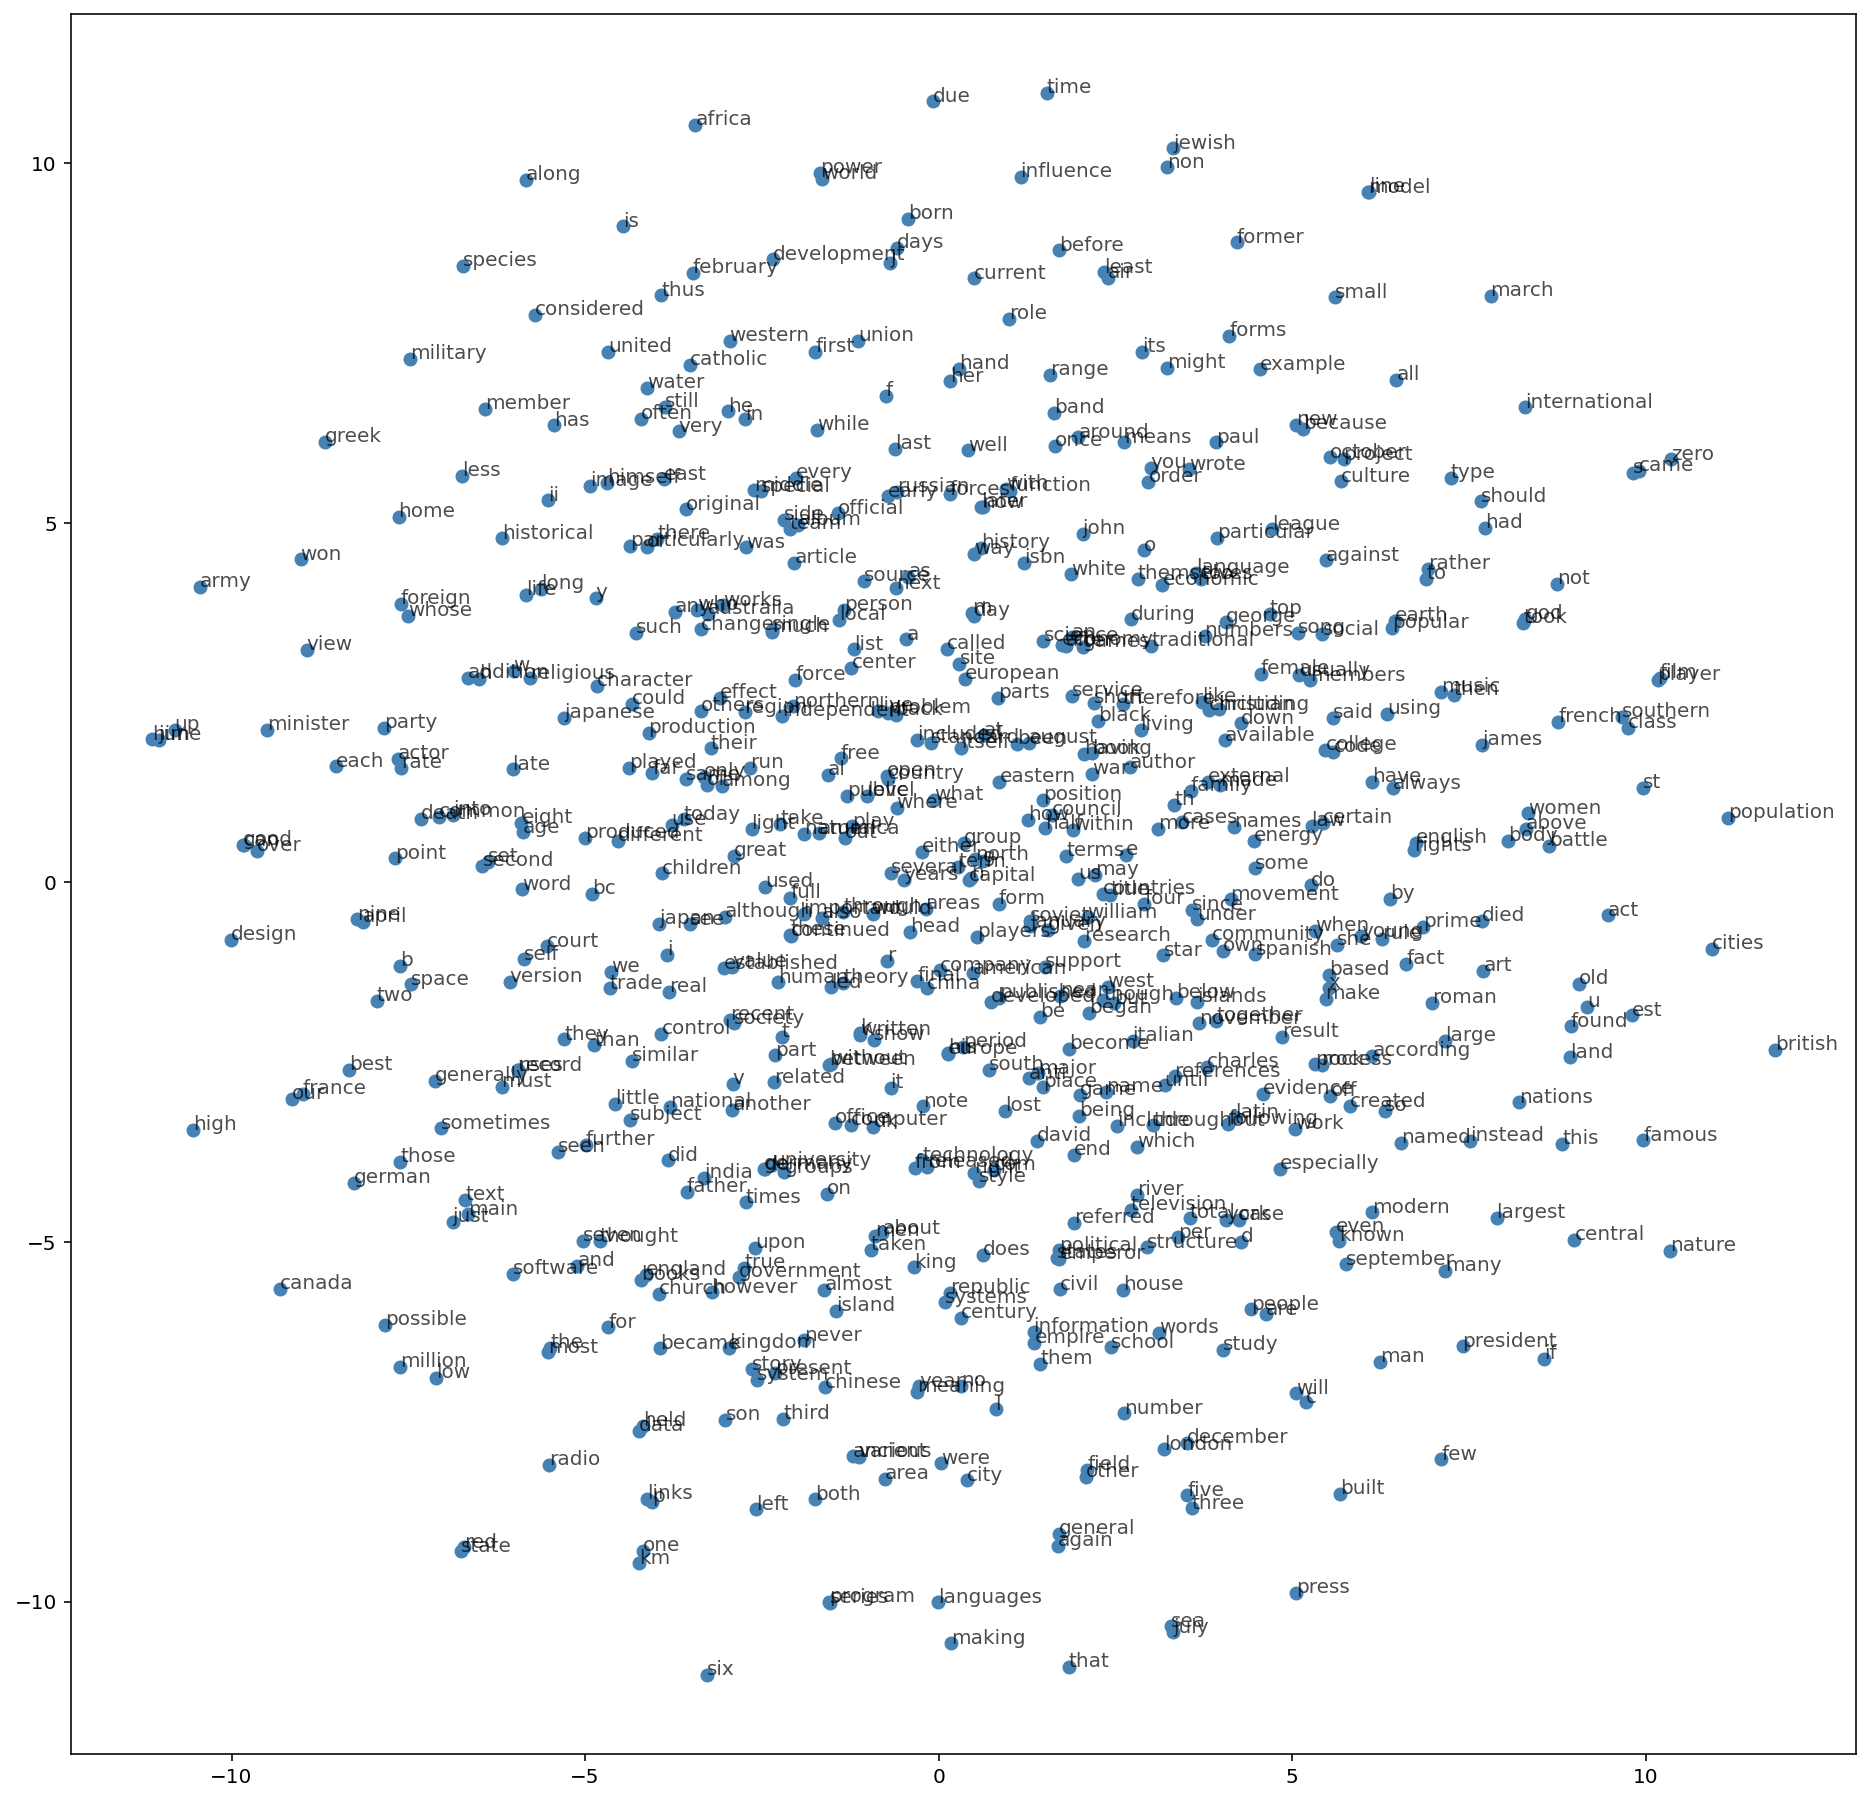

In [25]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)